## Оптимизация выполнения кода, векторизация, Numba

## Задачи для совместного разбора

In [8]:
import line_profiler
import numpy as np
from numba import jit
import pandas as pd
import random
import string
import timeit
import time

1. Сгенерируйте массив `A` из `N=1млн` случайных целых чисел на отрезке от 0 до 1000. Пусть `B[i] = A[i] + 100`. Посчитайте среднее значение массива `B`.

In [3]:
N = 1000000
A = np.random.randint(low=0, high=1001, size=N) 
B = A + 100 
mean_B = np.mean(B)

print(f"Среднее значение массива B: {mean_B}")

Среднее значение массива B: 599.9141


2. Создайте таблицу 2млн строк и с 4 столбцами, заполненными случайными числами. Добавьте столбец `key`, которые содержит элементы из множества английских букв. Выберите из таблицы подмножество строк, для которых в столбце `key` указаны первые 5 английских букв.

In [6]:
df = pd.DataFrame({'col1': [random.random() for _ in range(2000000)],
                   'col2': [random.random() for _ in range(2000000)],
                   'col3': [random.random() for _ in range(2000000)],
                   'col4': [random.random() for _ in range(2000000)]})


def random_string(length):
    return ''.join(random.choice(string.ascii_lowercase) for _ in range(length))

df['key'] = [random_string(5) for _ in range(2000000)]

sub = df[df['key'].str.match('[a-e]{5}')]
sub

,col1,col2,col3,col4,key
2486,0.738115,0.040778,0.243357,0.091882,beeba
4653,0.161228,0.809489,0.682168,0.498670,bdbac
8334,0.586140,0.512454,0.123007,0.219334,bdded
13565,0.351940,0.002811,0.008488,0.672380,cddec
20953,0.629156,0.631197,0.744952,0.772950,becde
...,...,...,...,...,...
1972948,0.439408,0.482295,0.444584,0.433914,ceeac
1979520,0.019370,0.666577,0.959046,0.385321,aedcc
1984436,0.643981,0.960380,0.692916,0.128538,adbbd
1987764,0.395183,0.018452,0.295181,0.475049,ecbbc


## Лабораторная работа 3

In [7]:
!pip install line_profiler
%load_ext line_profiler

1. В файлах `recipes_sample.csv` и `reviews_sample.csv` (__ЛР 2__) находится информация об рецептах блюд и отзывах на эти рецепты соответственно. Загрузите данные из файлов в виде `pd.DataFrame` с названиями `recipes` и `reviews`. Обратите внимание на корректное считывание столбца(ов) с индексами. Приведите столбцы к нужным типам.

Реализуйте несколько вариантов функции подсчета среднего значения столбца `rating` из таблицы `reviews` для отзывов, оставленных в 2010 году.

A. С использованием метода `DataFrame.iterrows` исходной таблицы;

Б. С использованием метода `DataFrame.iterrows` таблицы, в которой сохранены только отзывы за 2010 год;

В. С использованием метода `Series.mean`.

Проверьте, что результаты работы всех написанных функций корректны и совпадают. Измерьте выполнения всех написанных функций.


In [9]:
recipes = pd.read_csv('recipes_sample.csv')
reviews = pd.read_csv('reviews_sample.csv', index_col=0)

recipes['submitted'] = pd.to_datetime(recipes['submitted'])
reviews_2010 = reviews.loc[pd.DatetimeIndex(reviews['date']).year == 2010]

def mean_A(reviews):
    total = 0
    for _, row in reviews.iterrows():
        total += row['rating']
    return total / len(reviews)

def mean_B(reviews_2010):
    total = 0
    for _, row in reviews_2010.iterrows():
        total += row['rating']
    return total / len(reviews_2010)

def mean_C(reviews_2010):
    return reviews_2010['rating'].mean()

# Замер времени выполнения функций
time_A = timeit.timeit(lambda: mean_A(reviews_2010), number=1)

# Замер времени выполнения функции mean_rating_B
time_B = timeit.timeit(lambda: mean_B(reviews_2010), number=1)

# Замер времени выполнения функции mean_rating_C
time_C = timeit.timeit(lambda: mean_C(reviews_2010), number=1)

# Вывод результатов замеров времени
print('mean_A time:', time_A)
print('mean_B time:', time_B)
print('mean_C time:', time_C)

mean_A time: 0.21152070900001263
mean_B time: 0.21001612500000988
mean_C time: 0.00019791599999052778


2. Какая из созданных функций выполняется медленнее? Что наиболее сильно влияет на скорость выполнения? Для ответа использовать профайлер `line_profiler`. Сохраните результаты работы профайлера в отдельную текстовую ячейку и прокомментируйте результаты его работы.

(*). Сможете ли вы ускорить работу функции 1Б, отказавшись от использования метода `iterrows`, но не используя метод `mean`?

In [12]:
%lprun -f mean_rating_A mean_rating_A(reviews_2010)

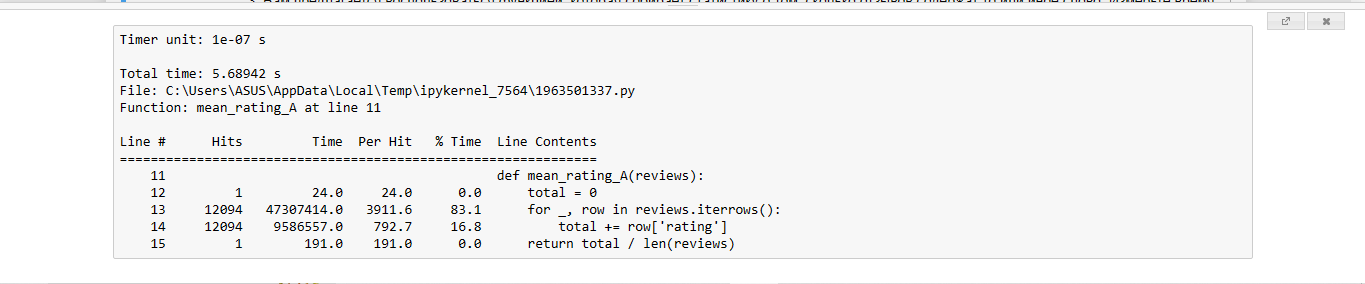

In [14]:
%lprun -f mean_rating_B mean_rating_B(reviews_2010)

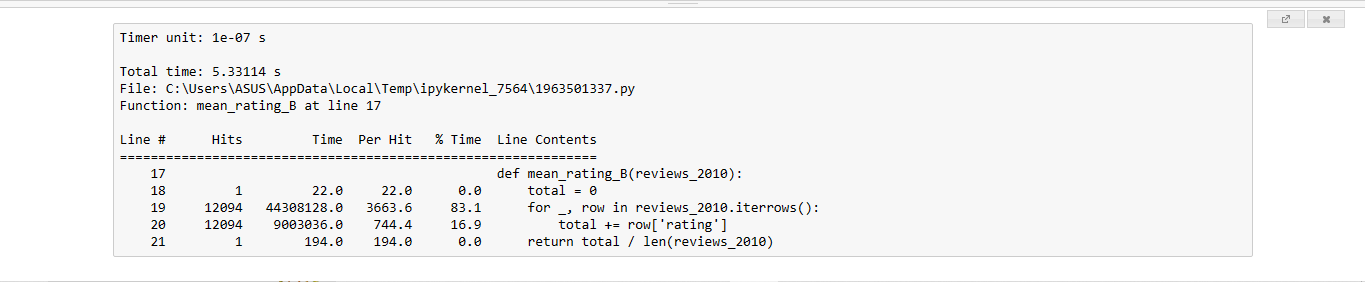

In [15]:
%lprun -f mean_rating_C mean_rating_C(reviews_2010)

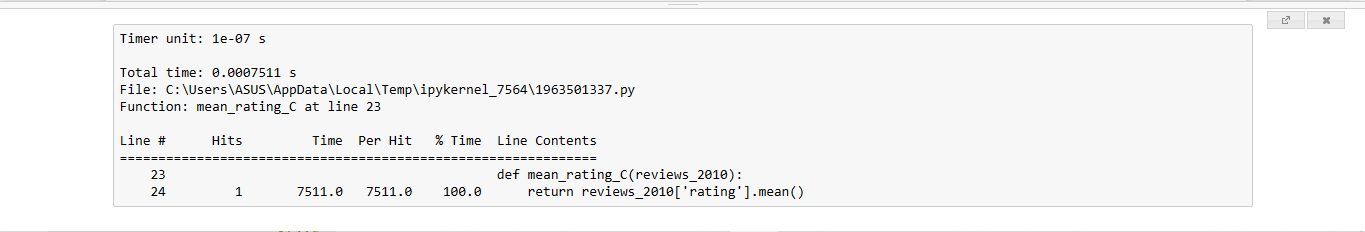

3. Вам предлагается воспользоваться функцией, которая собирает статистику о том, сколько отзывов содержат то или иное слово. Измерьте время выполнения этой функции. Сможете ли вы найти узкие места в коде, используя профайлер? Выпишите (словами), что в имеющемся коде реализовано неоптимально. Оптимизируйте функцию и добейтесь значительного (как минимум, на один порядок) прироста в скорости выполнения.

In [19]:
def get_word_reviews_count(df):
    word_reviews = {}
    for _, row in df.dropna(subset=['review']).iterrows():
        recipe_id, review = row['recipe_id'], row['review']
        words = review.split(' ')
        for word in words:
            if word not in word_reviews:
                word_reviews[word] = []
            word_reviews[word].append(recipe_id)
    
    word_reviews_count = {}
    for _, row in df.dropna(subset=['review']).iterrows():
        review = row['review']
        words = review.split(' ')
        for word in words:
            word_reviews_count[word] = len(word_reviews[word])
    return word_reviews_count

print(timeit.timeit(lambda: get_word_reviews_count(reviews_2010), number=1))

5.088115300000027


4. Напишите несколько версий функции `MAPE` (см. [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)) для расчета среднего абсолютного процентного отклонения значения рейтинга отзыва на рецепт от среднего значения рейтинга по всем отзывам для этого рецепта. 
    1. Без использования векторизованных операций и методов массивов `numpy` и без использования `numba`
    2. Без использования векторизованных операций и методов массивов `numpy`, но с использованием `numba`
    3. С использованием векторизованных операций и методов массивов `numpy`, но без использования `numba`
    4. C использованием векторизованных операций и методов массивов `numpy` и `numba`
    
Измерьте время выполнения каждой из реализаций.

Замечание: удалите из выборки отзывы с нулевым рейтингом.


In [10]:
recipes = pd.read_csv('recipes_sample.csv')
reviews = pd.read_csv('reviews_sample.csv', index_col=0)

df = reviews[['recipe_id', 'rating']].dropna()
df = df[df['rating'] != 0]
df = pd.merge(df, df.groupby(['recipe_id'])['rating'].mean().rename('mean_rating'), how='left', left_on='recipe_id', right_index=True)
df

,recipe_id,rating,mean_rating
370476,57993,5,4.818182
624300,142201,5,5.000000
187037,252013,4,4.000000
706134,404716,5,4.555556
312179,129396,5,5.000000
...,...,...,...
344676,314698,5,5.000000
1013457,335534,4,3.833333
1059834,222001,5,5.000000
453285,354979,5,4.064516


In [11]:
df_a = df['rating'].to_numpy()
df_b = df['mean_rating'].to_numpy()

In [12]:
def mape_a():
    n = len(df_a)
    return sum([abs(df_a[i] - df_b[i]) / df_a[i] for i in range(n)]) / n * 100
mape_a()

11.17155025905884

In [6]:
%timeit mape_a()

1.96 s ± 5.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
@jit(nopython = True)
def mape_b():
    n = len(df_a)
    return sum([abs(df_a[i] - df_b[i]) / df_a[i] for i in range(n)]) / n * 100
mape_b()

11.17155025905884

In [10]:
%timeit mape_b()

2.78 ms ± 56.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
def mape_c():
    return np.mean(np.fabs(df_a - df_b) / df_a) * 100
mape_c()

11.171550259058085

In [12]:
%timeit mape_c()

2.76 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
@jit(nopython = True)
def mape_d():
    return np.mean(np.fabs(df_a - df_b) / df_a) * 100
mape_d()

11.17155025905884

In [14]:
%timeit mape_d()

852 µs ± 26.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
